In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gurobipy import *

# we can also check different vehicle capacities for optimal routes

# the capacity of vehicle
vehicle_capacity = 300  

# the number of vehicle
vehicle_count = 5  

# customer count ('0' is depot) 
customer_count = 25

In [16]:
df = pd.read_csv(r'MVRP_400N.txt', sep = " ")
df = df.iloc[0:customer_count+1]

Y, X = list(df["Y"]), list(df["X"])
coordinates = np.column_stack((X, Y))

'''
et, lt, st = list(df["Et"]), list(df["Lt"]), list(df["St"])  # needed for time windows
'''
df.loc[0] = [1, 0.0, 0.0, 0.0, 0.0]
df

,Node,X,Y,Demand,Profit
0,1,0.0000,0.00,0.0,0.0
1,2,5.7735,0.00,40.0,16.0
2,3,2.8867,5.00,40.0,16.0
3,4,-2.8868,5.00,40.0,16.0
4,5,-5.7735,0.00,40.0,16.0
5,6,-2.8867,-5.00,40.0,16.0
6,7,2.8868,-5.00,40.0,16.0
7,8,8.6603,5.00,40.0,24.0
8,9,0.0000,10.00,40.0,24.0
9,10,-8.6603,5.00,40.0,24.0


In [17]:
Demand = list(df["Demand"])
n = len(coordinates)
depot, customers = coordinates[0, :], coordinates[1:, :]

# big number
M = 100**100  

m = Model("MVRP")

#intialize the decision variables
x, y, z = {}, {}, {}  

#distance matrix (32*32 array)
distance_matrix = np.empty([n, n])
for i in range(len(X)):
    for j in range(len(Y)):
        '''variable_1: X[i,j] =(0,1), i,j = Nodes'''
        x[i, j] = m.addVar(vtype=GRB.BINARY, name="x%d,%d" % (i, j))
        distance_matrix[i, j] = np.sqrt((X[i] - X[j]) ** 2 + (Y[i] - Y[j]) ** 2)
        if i == j:
            distance_matrix[i, j] = M  ## big 'M'
        continue
m.update()

'''variable_2: y[j] = cumulative demand covered'''
for j in range(n):
    # cumulative demand satisfied variable
    y[j] = m.addVar(vtype=GRB.INTEGER, name="y%d" % (j))   
    
    # cumulative time variable
    z[j] = m.addVar(vtype=GRB.INTEGER, name="z%d" % (j))   
m.update()

In [18]:
# vehicles leaving each customer node
'''constraint_1: sum(x[i,j]) = 1, for i = 1,2,...,32''' 

for i in range(n - 1):
    m.addConstr(quicksum(x[(i + 1, j)] for j in range(n)) == 1)
m.update()

# vehicles arriving to each customer node
''' constraint_2: sum(x[i,j] =1 for j = 1,2,.....,32)'''  
for j in range(n - 1):
    m.addConstr(quicksum(x[(i, j + 1)] for i in range(n)) == 1)
m.update()

# vehicles leaving depot
'''constraint_3: sum(x[0,j]) = 5'''  
m.addConstr(quicksum(x[(0, j)] for j in range(n)) == vehicle_count)
m.update()

# vehicles arriving to depot
'''constraint_4: sum(x[i,0]) = 5'''  
m.addConstr(quicksum(x[(i, 0)] for i in range(n)) == vehicle_count)
m.update()

# Either of the constraint_5 or the constrain_6 can eliminate sub-tours independently

'''constraint_5: capacity of vehicle and also eliminating sub-tours'''
for j in range(n - 1):
    m.addConstr(y[j + 1] <= vehicle_capacity)
    m.addConstr(y[j + 1] >= Demand[j + 1])
    for i in range(n - 1):
        m.addConstr(y[j + 1] >= y[i + 1] + Demand[j + 1] * (x[i + 1, j + 1]) - vehicle_capacity * (1 - (x[i + 1, j + 1])))
m.update()

# '''constraint_6: time-windows and also eliminating sub-tours'''

# for i in range(n - 1):
#     # assumption: service starts at 9:00 AM, 9 == 0 minutes, each hour after 9 is 60 minutes plus previous hours
#     m.addConstr(z[i + 1] >= (et[i + 1] - 9) * 60)  # service should start after the earliest service start time
#     m.addConstr(z[i + 1] <= (lt[i + 1] - 9) * 60)  # service can't be started after the latest service start time
#     for j in range(n - 1):
#         # taking the linear distance from one node to other as travelling time in minutes between those nodes
#         m.addConstr(z[i + 1] >= z[j + 1] + (st[j + 1] + dist_matrix[j + 1, i + 1]/100) * x[j + 1, i + 1] - M*(1-x[j+1, i+1]))
# m.update()

In [19]:
# objective function
m.setObjective(quicksum(quicksum(x[(i, j)]*distance_matrix[(i, j)] for j in range(n)) for i in range(n)),GRB.MINIMIZE)
m.update()

In [20]:
# optimize
m.optimize()

# retrieve the solution
sol_y, sol_x, sol_z = m.getAttr('x', y), m.getAttr('x', x), m.getAttr('x', z)
X, Y, Z = np.empty([n, n]), np.empty([n]), np.empty([n])
for i in range(n):
    Y[i] = sol_y[i]
    Z[i] = sol_z[i]
    for j in range(n):
        X[i, j] = int(sol_x[i, j])
print('\nObjective is:', m.objVal)
print('\nDecision variable X (binary decision of travelling from one node to another):\n', X.astype('int32'))
print('\nDecision variable z:(service start time of every customers in minutes)\n', Z.astype('int32')[1:])
print('\nDecision variable y (cumulative demand collected at every customer node):\n', Y.astype('int32')[1:])

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 727 rows, 728 columns and 3227 nonzeros
Model fingerprint: 0x5e52621b
Variable types: 0 continuous, 728 integer (676 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [9e-01, 1e+100]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 75 rows and 52 columns
Presolve time: 0.01s
Presolved: 652 rows, 676 columns, 3102 nonzeros
Variable types: 0 continuous, 676 integer (651 binary)
Found heuristic solution: objective 280.8462042

Root relaxation: objective 1.169026e+02, 126 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



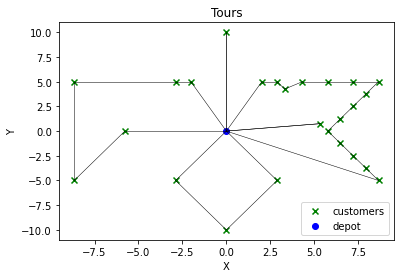

In [21]:
def _plot_tours(solution_x):
    tours = [[i, j] for i in range(solution_x.shape[0]) for j in range(solution_x.shape[1]) if solution_x[i, j] ==1]
    for t, tour in enumerate(tours):
        plt.plot(df["X"][tour], df["Y"][tour], color = "black", linewidth=0.5)
    plt.scatter(df["X"][1:], df["Y"][1:], marker = 'x', color = 'g', label = "customers")
    plt.scatter(df["X"][0], df["Y"][0], marker = "o", color = 'b', label = "depot")
    plt.xlabel("X"), plt.ylabel("Y"), plt.title("Tours"), plt.legend(loc = 4)
    plt.show()

_plot_tours(X)